# Finding the best dividend-yield stocks
*Which ones are paying the most while costing the least (and have good prospects)?*

---

*TIP:* Remember to save datasets frequently, speaking from experience, sometimes handling large data means stepping away from your computer to stay busy while waiting for a process to run. You don't want to go back to your computer to see that you need to restart the runtime and that data is lost.


## First, get a list of all publicly traded stocks in the Nasdaq index.

I downloaded a filed called *nasdaqtraded.txt* from *ftp.nasdaqtrader.com*. Basically go to the login screen, clikc on "SymbolDirectory" and there is a tab for public resources where you can download multiple text files.



In [ ]:
# Install dependencies
!pip install robin-stocks
!pip install yfinance

In [ ]:
# Import libraries
import json
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
with open('/content/drive/My Drive/nasdaqtraded.txt','r') as f:
  market_list = f.read()

# Take a look at the raw market data from the file
market_list.split('\n')[:5]

['Nasdaq Traded|Symbol|Security Name|Listing Exchange|Market Category|ETF|Round Lot Size|Test Issue|Financial Status|CQS Symbol|NASDAQ Symbol|NextShares',
 'Y|A|Agilent Technologies, Inc. Common Stock|N| |N|100|N||A|A|N',
 'Y|AA|Alcoa Corporation Common Stock |N| |N|100|N||AA|AA|N',
 'Y|AAAU|Perth Mint Physical Gold ETF|P| |Y|100|N||AAAU|AAAU|N',
 'Y|AACG|ATA Creativity Global - American Depositary Shares, each representing two common shares|Q|G|N|100|N|D||AACG|N']

As you can see, there are multiple fields separate by a "|" character. From here, we could convert the data to a JSON or a DataFrame. For this notebook we will start with a JSON format to add new fields and then go with a Pandas DataFrame to maintain readibility.

I won't go into detail about each column listed but you can get detailed information on each [here](http://www.nasdaqtrader.com/trader.aspx?id=symboldirdefs). 

The fields I will use are:
- Nasdaq Traded: Filter out the stocks that have a value of 'N' for 'Not traded'

- Test Issue: Filter out test tickers

- Symbol: Get the ticker symbol for each stock

- Sesurity Name: Name of company

- Listing Exchange: Keep only those in the NYSE, value is 'N'   **(EDIT: Keeping them all for now)**

- ETF: If it is an ETF or not

- Financial Status: Categorizes the health of a company with the following values:

  - D = Deficient: Issuer Failed to Meet NASDAQ Continued Listing Requirements
  - E = Delinquent: Issuer Missed Regulatory Filing Deadline
  - Q = Bankrupt: Issuer Has Filed for Bankruptcy
  - N = Normal (Default): Issuer Is NOT Deficient, Delinquent, or Bankrupt.
  - G = Deficient and Bankrupt
  - H = Deficient and Delinquent
  - J = Delinquent and Bankrupt
  - K = Deficient, Delinquent, and Bankrupt

In [ ]:
# Create DataFrame
market_data = [s.split('|') for s in market_list.split('\n')]
headers = [s.lower().replace(' ','_') for s in market_data[0]]
df = pd.DataFrame(market_data[1:], columns=headers)

print(len(df))
df.head(10)

8862


,nasdaq_traded,symbol,security_name,listing_exchange,market_category,etf,round_lot_size,test_issue,financial_status,cqs_symbol,nasdaq_symbol,nextshares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100,N,,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100,N,,AA,AA,N
2,Y,AAAU,Perth Mint Physical Gold ETF,P,,Y,100,N,,AAAU,AAAU,N
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100,N,D,,AACG,N
4,Y,AADR,AdvisorShares Dorsey Wright ADR ETF,P,,Y,100,N,,AADR,AADR,N
5,Y,AAL,"American Airlines Group, Inc. - Common Stock",Q,Q,N,100,N,N,,AAL,N
6,Y,AAMC,Altisource Asset Management Corp Com,A,,N,100,N,,AAMC,AAMC,N
7,Y,AAME,Atlantic American Corporation - Common Stock,Q,G,N,100,N,N,,AAME,N
8,Y,AAN,"Aaron's, Inc. Common Stock",N,,N,100,N,,AAN,AAN,N
9,Y,AAOI,"Applied Optoelectronics, Inc. - Common Stock",Q,G,N,100,N,N,,AAOI,N


In [ ]:
## Filter dataframe

# Drop unnecessary columns
orig_headers = ['Nasdaq Traded', 'Symbol', 'Security Name', 'Listing Exchange', 'ETF', 'Financial Status', 'Test Issue']
orig_headers_fixed = list(map(lambda x: x.lower().replace(' ','_'), orig_headers))
df = df[orig_headers_fixed]

# Keep only rows where nasdaq_traded equals 'Y' and listing_exchange equals 'N'
#df = df[(df['nasdaq_traded'] == 'Y') & (df['listing_exchange'] == 'N')]
df = df[(df['nasdaq_traded'] == 'Y') & (df['test_issue'] == 'N')]
print(len(df))
df.head(8)


8825


,nasdaq_traded,symbol,security_name,listing_exchange,etf,financial_status,test_issue
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,N,,N
1,Y,AA,Alcoa Corporation Common Stock,N,N,,N
2,Y,AAAU,Perth Mint Physical Gold ETF,P,Y,,N
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,N,D,N
4,Y,AADR,AdvisorShares Dorsey Wright ADR ETF,P,Y,,N
5,Y,AAL,"American Airlines Group, Inc. - Common Stock",Q,N,N,N
6,Y,AAMC,Altisource Asset Management Corp Com,A,N,,N
7,Y,AAME,Atlantic American Corporation - Common Stock,Q,N,N,N


## Adding additional financial information with Robin-Stocks and Yahoo Finance

We lowered our number of rows from 8862 to 8825. We can drop the *nasdaq_traded* and **NOT** *listing_exchange* columns as they have no variance anymore.

With this dataframe, we can beging adding more financial information such as dividends, latest price, and expert ratings.



In [ ]:
# Drop the aforementioned columns
df = df.drop(columns=['nasdaq_traded','test_issue'])  #,'listing_exchange']) 

In [ ]:
# Then we need to see how many null values are present in each column
print('NULL values')
print(df.isnull().sum())
print('-----------------')
print('N/A values')
print(df.isna().sum())


NULL values
symbol              0
security_name       0
listing_exchange    0
etf                 0
financial_status    0
dtype: int64
-----------------
N/A values
symbol              0
security_name       0
listing_exchange    0
etf                 0
financial_status    0
dtype: int64


Interestingly, it seems there are no empty cells in the DataFrame. Yet, we see that there are rows with no information under the "Financial Status" column.

To solve this, we will look at the set of unique values for this column.

In [ ]:
df.groupby('financial_status')['symbol'].nunique()

financial_status
     5280
D     260
E      10
H       7
N    3268
Name: symbol, dtype: int64

5280 out of 8825 (59.8%) of all companies have an absent "Financial Status" marker.

Let's not drop this yet, maybe we can continue without it or make a prediction based on other features?


> Listing Exchanges:
- A = NYSE MKT
- N = New York Stock Exchange (NYSE)
- P = NYSE ARCA
- Z = BATS Global Markets (BATS)
- V = Investors' Exchange, LLC (IEXG)



## Visualize the distribution of Financial Status values in each Listing Exchane

In [ ]:
# Split dataframe into multiple dataframes by listing exchange
exchange_mapping = {'A':'NYSE MKT','N':'NYSE','P':'NYSE ARCA','Z':'BATS','V':'IEXG','Q':'IEXG'}

exchanges = list(set(df.listing_exchange.values))
financial_status = list(set(df.financial_status.values))

fin_status_counts = np.zeros((len(exchanges),len(financial_status)))

for num, ex in enumerate(exchanges):
  exdf = df[df['listing_exchange'] == ex]['financial_status'].value_counts()
  for idx, row in zip(exdf.index, exdf.values):
    fin_status_counts[num][financial_status.index(idx)] = row

print(exchanges)
print(financial_status)
print(fin_status_counts.T)
  

['A', 'Q', 'Z', 'N', 'P']
['', 'D', 'N', 'E', 'H']
[[ 289.    0.  365. 3077. 1549.]
 [   0.  260.    0.    0.    0.]
 [   0. 3268.    0.    0.    0.]
 [   0.   10.    0.    0.    0.]
 [   0.    7.    0.    0.    0.]]


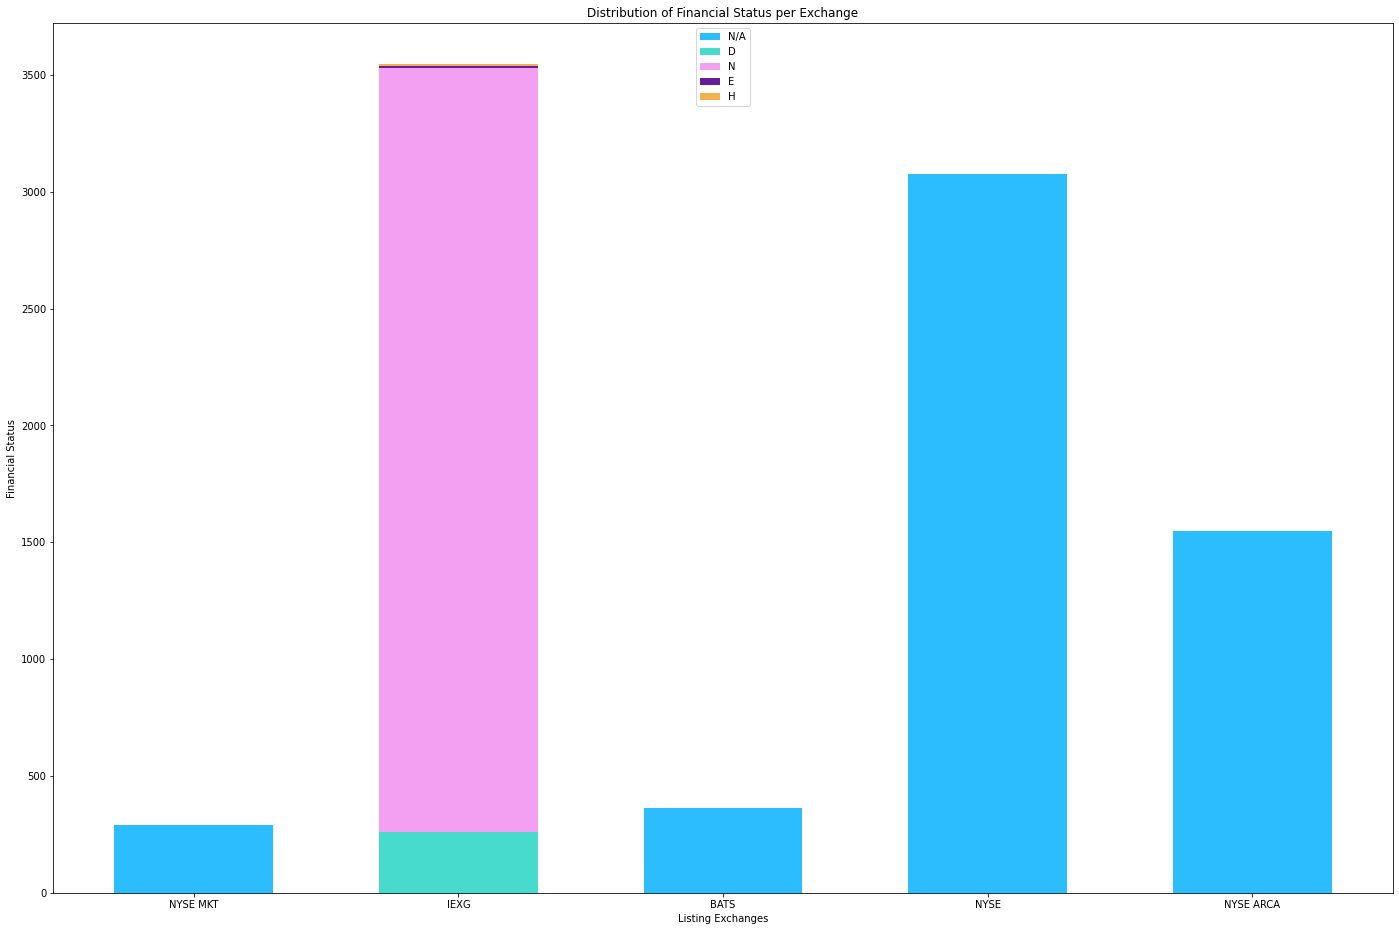

In [ ]:
# Plot the data arranged as a 2-D numpy array
x_labels = list(map(lambda x: exchange_mapping[x], exchanges))
# Transport the 2D array
transposed_fs = fin_status_counts.T

plt.figure(figsize=(24,16))

color_scheme = ['#2CBDFE','#47DBCD','#F3A0F2','#661D98','#F5B14C']
bottoms = []
for num, val in enumerate(transposed_fs):
  if financial_status[num] == '':
    financial_status[num] = 'N/A'
  if num == 0:
    plt.bar(x_labels, val, width=0.6, label=financial_status[num], color=color_scheme[num])
    bottom = val
  else:
    plt.bar(x_labels, val, width=0.6, label=financial_status[num], color=color_scheme[num], bottom=bottom)
    bottom += val

plt.xticks(x_labels, x_labels)
plt.ylabel("Financial Status")
plt.xlabel("Listing Exchanges")
plt.legend(loc="upper center")
plt.title("Distribution of Financial Status per Exchange")
plt.show()


It seems only IEXG has financial status data. Therefore, we can ignore the field for now and continue adding financial data from Yahoo Finance to each ticker.

## Get financial data from Yahoo Finance

In [ ]:
# Create a list of symbols/tickers
symbol_list = df.symbol.to_list()

# Read the documentation and selected the fields I want to keep
info_to_keep = '''zip, sector, fullTimeEmployees, city, state, country, industry, previousClose,
regularMarketOpen, twoHundredDayAverage, trailingAnnualDividendYield, payoutRatio,
regularMarketDayHigh, averageDailyVolume10Day, regularMarketPreviousClose, fiftyDayAverage,
trailingAnnualDividendRate, open, averageVolume10days, dividendRate, regularMarketDayLow,
trailingPE, regularMarketVolume, marketCap, averageVolume, dayLow, ask, askSize,
volume, fiftyTwoWeekHigh, forwardPE, fiveYearAvgDividendYield, fiftyTwoWeekLow,
bid, dividendYield, bidSize, dayHigh, enterpriseToRevenue, profitMargins,
52WeekChange, forwardEps, revenueQuarterlyGrowth, bookValue, sharesShort, sharesPercentSharesOut,
heldPercentInstitutions, shortRatio, floatShares, enterpriseValue, regularMarketPrice'''
info_to_keep_list = info_to_keep.split(', ')

list_of_additional_info = []
for symbol in symbol_list:
  try:
    # Get ticker object
    ticker = yf.Ticker(symbol)
    # Keep only relevant fields
    ticker_info = {k:v for k,v in ticker.info.items() if k in info_to_keep_list}
    # Add the latest dividend given
    ticker_info['latest_dividend'] = ticker.dividends[-1]
    # Include symbol to 
    ticker_info['symbol'] = symbol
    list_of_additional_info.append(ticker_info)
  except Exception as e:
    # The ticker is not available in Yahoo Finance, or at least it has no data
    # related to it
    continue
  

# Other dataframes to keep for future use:
# dividends, sustainability, calendar, recommendations

# Save the file as a CSV just in case
sample_df = pd.DataFrame(list_of_additional_info)
print(len(sample_df))
#sample_df.to_csv('###########',index=False)
  

### **PSA**

Now the method above is a **BAD IDEA** when looping through so much data. I would recommend using some type of multiprocessing or parallel library to speed up the process. Google Colab is more than equipped to do so.

**Remember:** avoid for loops for stuff like this unless you're okay waiting for 1 hour or more.

In [ ]:
sample_df.head()

,zip,sector,fullTimeEmployees,city,state,country,industry,twoHundredDayAverage,trailingAnnualDividendYield,averageDailyVolume10Day,regularMarketPreviousClose,open,averageVolume10days,dividendRate,regularMarketVolume,marketCap,averageVolume,dayLow,ask,fiftyTwoWeekHigh,forwardPE,fiveYearAvgDividendYield,dividendYield,bidSize,dayHigh,enterpriseToRevenue,forwardEps,revenueQuarterlyGrowth,bookValue,sharesShort,shortRatio,floatShares,enterpriseValue,regularMarketPrice,latest_dividend,symbol
0,95051,Healthcare,16300.0,Santa Clara,CA,United States,Diagnostics & Research,79.984190,0.007802,2807514,86.130,86.30,2807514,0.72,1847602,2.654344e+10,2616254,84.3700,87.20,90.64,24.140057,0.92,0.0084,1400.0,86.480,4.987,3.57,NaN,15.636,5258241.0,2.55,308518035.0,2.611031e+10,86.30,0.180,A
1,15212,Basic Materials,13800.0,Pittsburgh,PA,United States,Aluminum,13.778677,0.041096,9643371,8.760,9.12,9643371,NaN,11237725,1.814570e+09,9784741,8.9250,9.90,24.63,-40.666668,NaN,NaN,1800.0,9.790,0.417,-0.24,NaN,22.994,11633009.0,1.10,185121237.0,4.210365e+09,9.12,0.090,AA
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.253677,NaN,3914,48.275,47.59,3914,NaN,3019,NaN,18675,47.3664,0.00,57.51,NaN,NaN,NaN,800.0,48.221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.59,0.008,AADR
3,76155,Industrials,131500.0,Fort Worth,TX,United States,Airlines,20.709190,0.035907,66709542,11.140,12.43,66709542,0.40,99314752,5.066270e+09,69955775,11.0700,11.94,34.99,-299.500000,1.14,0.0359,4000.0,12.550,0.796,-0.04,NaN,-6.233,119303588.0,1.49,416754073.0,3.478515e+10,12.43,0.100,AAL
4,30319,Financial Services,151.0,Atlanta,GA,United States,Insurance—Life,2.017721,0.010256,1185,1.950,1.95,1185,NaN,453,3.832200e+07,2308,1.8300,0.00,2.95,NaN,0.65,NaN,800.0,1.950,0.371,NaN,NaN,4.964,1620.0,0.46,4879047.0,6.778967e+07,1.95,0.020,AAME


## Merge datasets

We now have two datasets --one with the ticker's financial data from Yahoo Finance and the first one that contains basic information-- which we used to get all the stocks that are traded in Nasdaq.

We can merge them now and filter out the symbols that are not in the Yahoo Finance dataframe.

In [ ]:
merged_df = pd.merge(df, sample_df, on='symbol')
print(len(merged_df))
merged_df.head()

4447


,symbol,security_name,listing_exchange,etf,financial_status,zip,sector,fullTimeEmployees,city,state,country,industry,twoHundredDayAverage,trailingAnnualDividendYield,averageDailyVolume10Day,regularMarketPreviousClose,open,averageVolume10days,dividendRate,regularMarketVolume,marketCap,averageVolume,dayLow,ask,fiftyTwoWeekHigh,forwardPE,fiveYearAvgDividendYield,dividendYield,bidSize,dayHigh,enterpriseToRevenue,forwardEps,revenueQuarterlyGrowth,bookValue,sharesShort,shortRatio,floatShares,enterpriseValue,regularMarketPrice,latest_dividend
0,A,"Agilent Technologies, Inc. Common Stock",N,N,,95051,Healthcare,16300.0,Santa Clara,CA,United States,Diagnostics & Research,79.984190,0.007802,2807514,86.130,86.30,2807514,0.72,1847602,2.654344e+10,2616254,84.3700,87.20,90.64,24.140057,0.92,0.0084,1400.0,86.480,4.987,3.57,NaN,15.636,5258241.0,2.55,308518035.0,2.611031e+10,86.30,0.180
1,AA,Alcoa Corporation Common Stock,N,N,,15212,Basic Materials,13800.0,Pittsburgh,PA,United States,Aluminum,13.778677,0.041096,9643371,8.760,9.12,9643371,NaN,11237725,1.814570e+09,9784741,8.9250,9.90,24.63,-40.666668,NaN,NaN,1800.0,9.790,0.417,-0.24,NaN,22.994,11633009.0,1.10,185121237.0,4.210365e+09,9.12,0.090
2,AADR,AdvisorShares Dorsey Wright ADR ETF,P,Y,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.253677,NaN,3914,48.275,47.59,3914,NaN,3019,NaN,18675,47.3664,0.00,57.51,NaN,NaN,NaN,800.0,48.221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.59,0.008
3,AAL,"American Airlines Group, Inc. - Common Stock",Q,N,N,76155,Industrials,131500.0,Fort Worth,TX,United States,Airlines,20.709190,0.035907,66709542,11.140,12.43,66709542,0.40,99314752,5.066270e+09,69955775,11.0700,11.94,34.99,-299.500000,1.14,0.0359,4000.0,12.550,0.796,-0.04,NaN,-6.233,119303588.0,1.49,416754073.0,3.478515e+10,12.43,0.100
4,AAME,Atlantic American Corporation - Common Stock,Q,N,N,30319,Financial Services,151.0,Atlanta,GA,United States,Insurance—Life,2.017721,0.010256,1185,1.950,1.95,1185,NaN,453,3.832200e+07,2308,1.8300,0.00,2.95,NaN,0.65,NaN,800.0,1.950,0.371,NaN,NaN,4.964,1620.0,0.46,4879047.0,6.778967e+07,1.95,0.020


#### Keep only dividend stocks

Now that we have a dataset with full financial data per stock, we can filter it down to keep only ones that have dividends.

In [ ]:
len(merged_df[(merged_df['dividendRate'].isnull() == False) & (merged_df['latest_dividend'].isnull() == False)])

dividend_df = merged_df[(merged_df['dividendRate'].isnull() == False) & (merged_df['latest_dividend'].isnull() == False)]
dividend_df.head()

,symbol,security_name,listing_exchange,etf,financial_status,zip,sector,fullTimeEmployees,city,state,country,industry,twoHundredDayAverage,trailingAnnualDividendYield,averageDailyVolume10Day,regularMarketPreviousClose,open,averageVolume10days,dividendRate,regularMarketVolume,marketCap,averageVolume,dayLow,ask,fiftyTwoWeekHigh,forwardPE,fiveYearAvgDividendYield,dividendYield,bidSize,dayHigh,enterpriseToRevenue,forwardEps,revenueQuarterlyGrowth,bookValue,sharesShort,shortRatio,floatShares,enterpriseValue,regularMarketPrice,latest_dividend
0,A,"Agilent Technologies, Inc. Common Stock",N,N,,95051,Healthcare,16300.0,Santa Clara,CA,United States,Diagnostics & Research,79.98419,0.007802,2807514,86.13,86.30,2807514,0.72,1847602,2.654344e+10,2616254,84.37,87.20,90.64,24.140057,0.92,0.0084,1400.0,86.48,4.987,3.57,NaN,15.636,5258241.0,2.55,3.085180e+08,2.611031e+10,86.30,0.18
3,AAL,"American Airlines Group, Inc. - Common Stock",Q,N,N,76155,Industrials,131500.0,Fort Worth,TX,United States,Airlines,20.70919,0.035907,66709542,11.14,12.43,66709542,0.40,99314752,5.066270e+09,69955775,11.07,11.94,34.99,-299.500000,1.14,0.0359,4000.0,12.55,0.796,-0.04,NaN,-6.233,119303588.0,1.49,4.167541e+08,3.478515e+10,12.43,0.10
5,AAP,Advance Auto Parts Inc Advance Auto Parts Inc W/I,N,N,,27604,Consumer Cyclical,39000.0,Raleigh,NC,United States,Specialty Retail,133.39670,0.001770,1514942,135.58,137.50,1514942,1.00,798726,9.792332e+09,1208891,136.31,141.63,171.43,16.593678,0.18,0.0071,1300.0,141.78,1.175,8.54,NaN,51.606,1691705.0,1.57,6.857524e+07,1.141075e+10,137.50,0.25
6,AAPL,Apple Inc. - Common Stock,Q,N,N,95014,Technology,137000.0,Cupertino,CA,United States,Consumer Electronics,286.99980,0.009724,27552328,316.73,316.14,27552328,3.28,26969168,1.378794e+12,50365603,313.09,316.98,327.85,21.596062,1.59,0.0103,800.0,318.71,5.108,14.73,NaN,18.137,33592445.0,0.89,4.329827e+09,1.368917e+12,316.14,0.82
7,AAT,"American Assets Trust, Inc. Common Stock",N,N,,92130,Real Estate,205.0,San Diego,CA,United States,REIT—Diversified,37.83544,0.042963,349871,27.00,28.01,349871,0.80,330037,1.687307e+09,454533,27.21,31.42,49.26,20.807407,2.59,0.0296,800.0,28.52,7.849,1.35,NaN,21.713,706006.0,1.70,5.308802e+07,2.936203e+09,28.01,0.30



## Clean Dividend Stock Data


We will be using the the *feature_selector* library to remove fields that are not necessary.

In [ ]:
# Install dependencies -- keep in mind, you may need to restart the runtime,
# so be sure to save the dataframes before doing so
!pip install feature_selector

In [ ]:
from feature_selector import FeatureSelector
import pandas as pd

# Here I am loading the CSV from my google drive
dividend_df = pd.read_csv('/content/drive/My Drive/dividend_stocks_only.csv')

fs = FeatureSelector(data=dividend_df, labels=list(dividend_df.columns.values))

### Identify Missing Features

In [ ]:
# Find columns, also known as features, that have 30% or more of their data missing
# These columns can be eliminated
fs.identify_missing(missing_threshold=0.3)

# Get a table showing the fraction of missing data per column
fs.missing_stats

4 features with greater than 0.30 missing values.



,missing_fraction
revenueQuarterlyGrowth,1.000000
financial_status,0.673027
forwardPE,0.303249
forwardEps,0.302218
fullTimeEmployees,0.293450
floatShares,0.224342
fiveYearAvgDividendYield,0.220732
enterpriseToRevenue,0.115008
trailingAnnualDividendYield,0.087674
state,0.080970


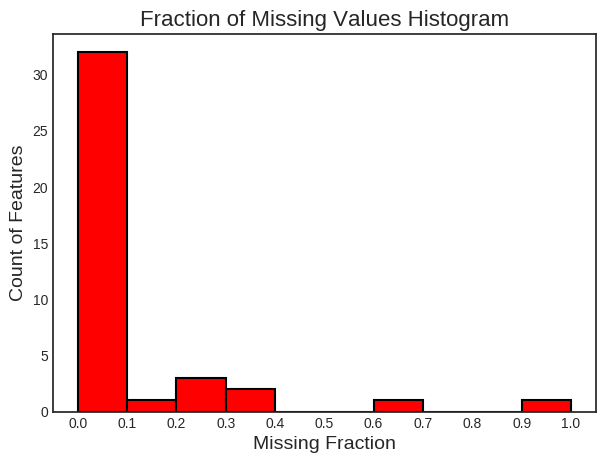

In [ ]:
# Plot the data to visually examine the extent of missing data
fs.plot_missing()

The bar chart above demonstrates that out of 40 labels/features/columns/however you want to call them: 

- 32 had less than 10% data missing
- 1 had between 10% and 20% data missing
- 3 had between 20% to 30% of data missing
- 2 had more than 30% but less than 40% of data missing
- 1 had between 60% to 70% of its data missing
- 1 field was completely empty of data

### Identify Collinear Features

These are features that have a high correlation between the values they share between each other. For example, if one column's value increases at the same rate as another. It's better to just keep one of them instead of both if you will use that data for Machine Learning.

In [ ]:
# Find features that are highly correlated -- more than 98%
fs.identify_collinear(correlation_threshold=0.98)
# Get list of related features
fs.ops['collinear']

6 features with a correlation magnitude greater than 0.98.



['regularMarketPreviousClose',
 'open',
 'averageVolume10days',
 'dayLow',
 'dayHigh',
 'regularMarketPrice']

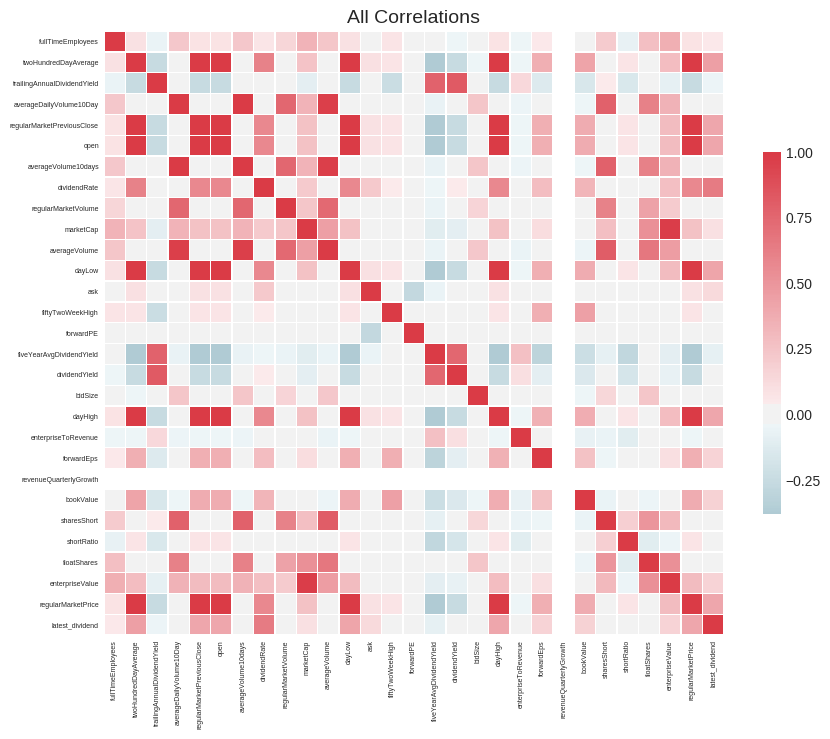

In [ ]:
# Plot the correlation matrix
fs.plot_collinear(plot_all=True)

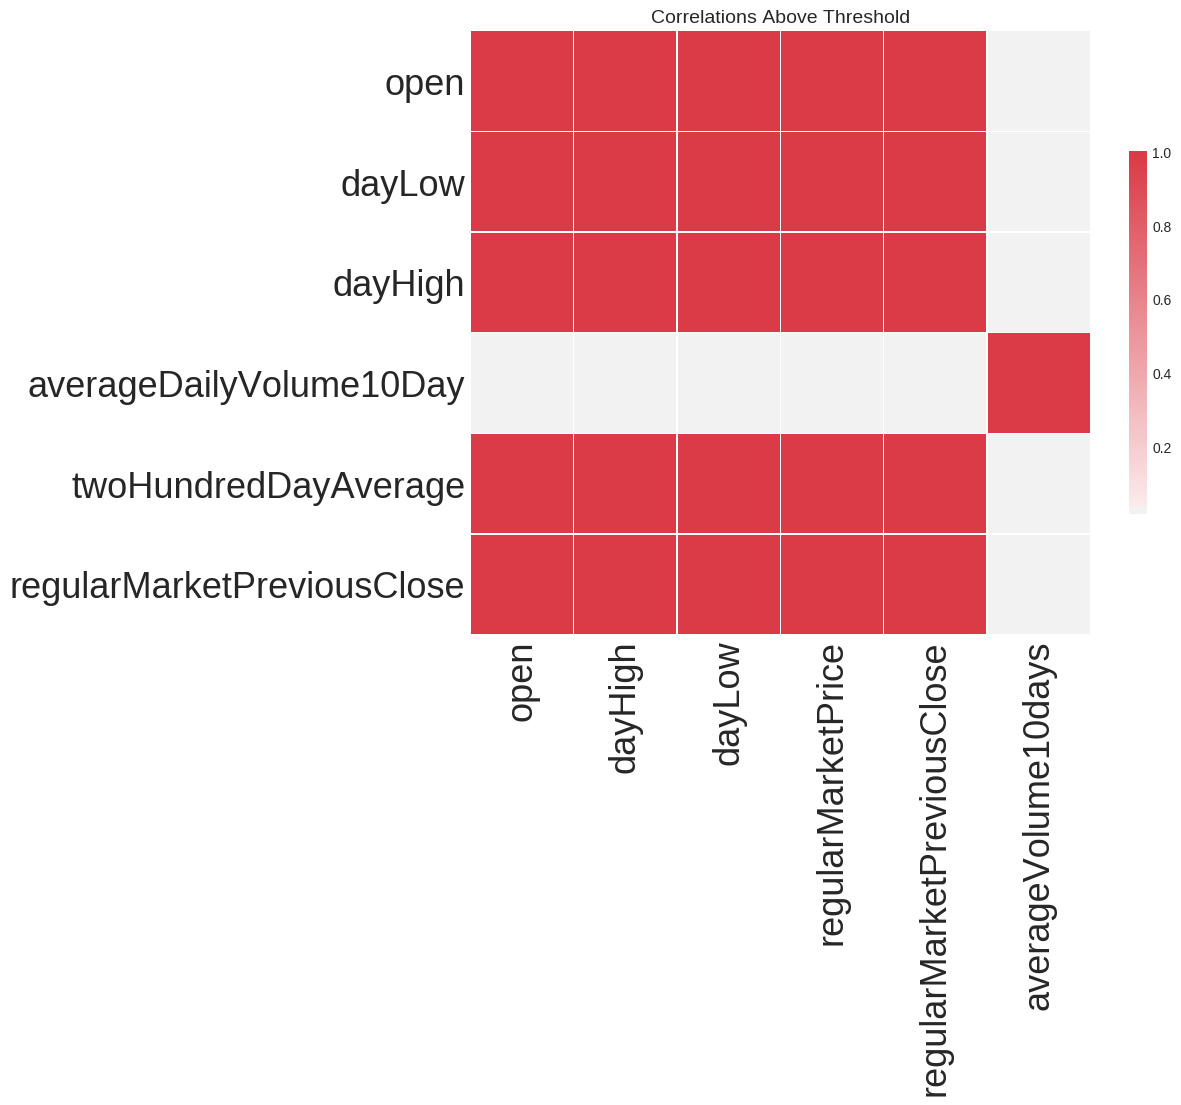

In [ ]:
# Plot only highly correlated features
fs.plot_collinear()

Now, we may not want to drop all these features but we can certainly choose to drop some of them. In my case, I'll drop *averageVolume10days*, *regularMarketPreviousClose*, and *twoHundredDayAverage*.

In the future, I may choose to drop more, but for now I think this is safe to do.

### Identify Single Unique Values

Sometimes we see that the values for all rows in a column are the exact same. If they offer no variety, we can eliminate the feature.

In [ ]:
# Check how many features have a single unique value
fs.identify_single_unique()
# Get the list of features
fs.ops['single_unique']

1 features with a single unique value.



['etf']

So it seems none of the stocks we have are ETFs (_ _ sad face :'( _ _ ). Well if that is the case, let's confirm and drop if needed.  

In [ ]:
dividend_df['etf'].value_counts()

N    1939
Name: etf, dtype: int64

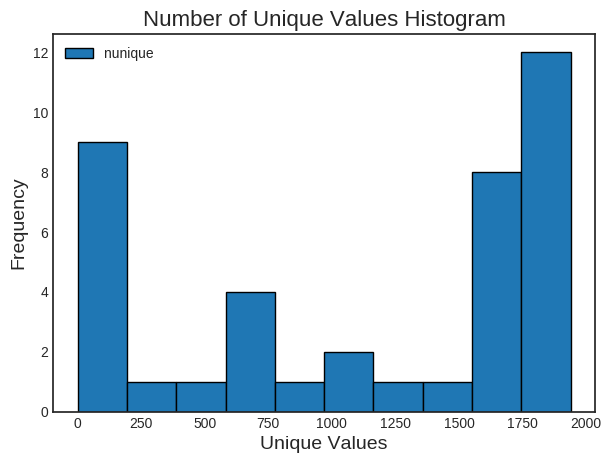

In [ ]:
# Confirmed so let's drop the field
features_to_drop = fs.ops['single_unique']
# Plot just for fun at this point
fs.plot_unique()

### Drop the features identified with feature_selector



In [ ]:
features_to_drop.extend(['averageVolume10days','regularMarketPreviousClose','twoHundredDayAverage'])
features_to_drop.extend(fs.ops['missing'])
features_to_drop

['etf',
 'averageVolume10days',
 'regularMarketPreviousClose',
 'twoHundredDayAverage',
 'financial_status',
 'forwardPE',
 'forwardEps',
 'revenueQuarterlyGrowth']

In [ ]:
clean_df = dividend_df.drop(features_to_drop, axis=1)
clean_df.head()

,symbol,security_name,listing_exchange,zip,sector,fullTimeEmployees,city,state,country,industry,trailingAnnualDividendYield,averageDailyVolume10Day,open,dividendRate,regularMarketVolume,marketCap,averageVolume,dayLow,ask,fiftyTwoWeekHigh,fiveYearAvgDividendYield,dividendYield,bidSize,dayHigh,enterpriseToRevenue,bookValue,sharesShort,shortRatio,floatShares,enterpriseValue,regularMarketPrice,latest_dividend
0,A,"Agilent Technologies, Inc. Common Stock",N,95051,Healthcare,16300.0,Santa Clara,CA,United States,Diagnostics & Research,0.007802,2807514,86.30,0.72,1847602,2.654344e+10,2616254,84.37,87.20,90.64,0.92,0.0084,1400.0,86.48,4.987,15.636,5258241.0,2.55,3.085180e+08,2.611031e+10,86.30,0.18
1,AAL,"American Airlines Group, Inc. - Common Stock",Q,76155,Industrials,131500.0,Fort Worth,TX,United States,Airlines,0.035907,66709542,12.43,0.40,99314752,5.066270e+09,69955775,11.07,11.94,34.99,1.14,0.0359,4000.0,12.55,0.796,-6.233,119303588.0,1.49,4.167541e+08,3.478515e+10,12.43,0.10
2,AAP,Advance Auto Parts Inc Advance Auto Parts Inc W/I,N,27604,Consumer Cyclical,39000.0,Raleigh,NC,United States,Specialty Retail,0.001770,1514942,137.50,1.00,798726,9.792332e+09,1208891,136.31,141.63,171.43,0.18,0.0071,1300.0,141.78,1.175,51.606,1691705.0,1.57,6.857524e+07,1.141075e+10,137.50,0.25
3,AAPL,Apple Inc. - Common Stock,Q,95014,Technology,137000.0,Cupertino,CA,United States,Consumer Electronics,0.009724,27552328,316.14,3.28,26969168,1.378794e+12,50365603,313.09,316.98,327.85,1.59,0.0103,800.0,318.71,5.108,18.137,33592445.0,0.89,4.329827e+09,1.368917e+12,316.14,0.82
4,AAT,"American Assets Trust, Inc. Common Stock",N,92130,Real Estate,205.0,San Diego,CA,United States,REIT—Diversified,0.042963,349871,28.01,0.80,330037,1.687307e+09,454533,27.21,31.42,49.26,2.59,0.0296,800.0,28.52,7.849,21.713,706006.0,1.70,5.308802e+07,2.936203e+09,28.01,0.30


In [ ]:
clean_df.to_csv('/content/drive/My Drive/optimized_dividend_stocks.csv', index=False)

# Next Steps

## Further optimization of dataset

---

The dataset can be optimized with additional methods offered from FeatureSelector and we could also use the featuretools library to automatically generate more features.

In addition, we could get data from other sources such as Bloomberg or Robinhood via robin-stocks.

## Exploratory Data Analysis

---

Stock data can be examined through simple techniques to wrangle data or create comprehensive visualizations. 

Through this we can answer questions like 'which sector pays the best dividends?', 'are there any features that could predict business performance for a company?', 'where do different sectors concentrate their business in?', or any other you can think of.

In [ ]:
# Thank you for reading

# Please feel free to star the repository and/or provide me with any feedback you have :)